# Fraud Detection in Electricity and Gas Consumption

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.

The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.

# Team 5

## Data analysis and inspection

First thing we need to do is import the neccessary packages that we are going to be using.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

sns.set()

%matplotlib inline

Loading the datasets into our file as a pandas dataframe

In [2]:
client_data = pd.read_csv('client_train.csv',low_memory = False)
invoice_data = pd.read_csv('invoice_train.csv',low_memory = False)

Taking a peek at the client dataset to see what kind of monster we are dealing with.

In [3]:
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [4]:
client_data.shape

(135493, 6)

We also look at the invoice dataset

In [5]:
invoice_data.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [6]:
invoice_data.shape

(4476749, 16)

We see that we can immediatly calculate how many invoices there are per client and add that to our dataframe

In [7]:
client_data['invoice_amount'] = invoice_data.groupby('client_id').size().values
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount
0,60,train_Client_0,11,101,31/12/1994,0.0,35
1,69,train_Client_1,11,107,29/05/2002,0.0,37
2,62,train_Client_10,11,301,13/03/1986,0.0,18
3,69,train_Client_100,11,105,11/07/1996,0.0,20
4,62,train_Client_1000,11,303,14/10/2014,0.0,14


We also see that we can change the dates to datetime format incase we will be needing that information later

In [8]:
# Changing the client_data's column date to datetime
client_data['creation_date']= pd.to_datetime(client_data['creation_date'])
# Changing the invoice_data's column date to datetime
invoice_data['invoice_date']= pd.to_datetime(invoice_data['invoice_date'])

The date can be used to calculate how long a customer has had a contract with the company because it might be usefull in our model

In [9]:
today = pd.to_datetime("today")
# Add the contract length in years 
client_data['contract_time_length'] = today.year - client_data['creation_date'].dt.year
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7


The date of the last invoice can differ a lot from the current date and so the number of years since the start of a clients contract with the company and the date of their last invoice will be used as well.

In [10]:
client_data['contract_time_to_latest'] = invoice_data.groupby('client_id')['invoice_date'].max().dt.year.values- client_data['creation_date'].dt.year.values
    
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length,contract_time_to_latest
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27,25
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19,17
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35,33
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25,16
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7,5


Detailed decriptions of the old and new index columns was not given for the dataset however is thought that the change in this index might be of value.

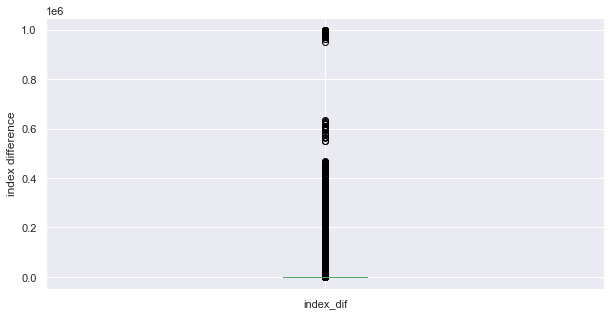

In [11]:
fig,ax = plt.subplots(figsize=(10,5))
invoice_data['index_dif'] = np.abs(invoice_data['new_index']-invoice_data['old_index'])

invoice_data.loc[:,'index_dif'].plot(kind='box')
plt.ylabel('index difference');

There are large fluctuations in the difference of this value. Seeing how large difference values correspond to fraudulent clients is shown below:

In [12]:
print('0.75 quantile: ',invoice_data['index_dif'].quantile(0.75))
index_index_dif = invoice_data.merge(client_data,on='client_id')[invoice_data['index_dif'] > 2500]['target'].index

0.75 quantile:  657.0


In [13]:
invoice_data.drop(index = index_index_dif,inplace = True)

8.8% of the values greater than the 0.75 quantile corresponds to fraudulent clients

The months number column was also not well defined. It is seen that this number is how many months have passed since the last invoice/inspection. However there are large outiers for this feature corresponding to 200+ years since the last invoice.

In [14]:
invoice_data['months_number'].describe()

count    4.326056e+06
mean     4.256167e+00
std      1.692287e+01
min      0.000000e+00
25%      4.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      2.043300e+04
Name: months_number, dtype: float64

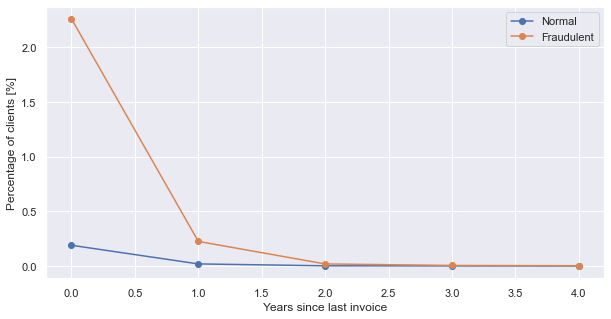

In [15]:
month_check = invoice_data[:].merge(client_data,on='client_id')
months =[]
for i in range(5):
    months.append(month_check[(month_check['months_number']>i*12)&(month_check['target']==1)].groupby('client_id').sum().shape[0])
    
fig,ax = plt.subplots(figsize=(10,5))
plt.plot((np.array(months)/month_check[month_check['target']==0].shape[0])*100,marker='o',label='Normal')
plt.plot((np.array(months)/month_check[month_check['target']==1].shape[0])*100,marker='o',label='Fraudulent')
plt.legend()
plt.ylabel('Percentage of clients [%]');
plt.xlabel('Years since last invoice');

As shown in the above graph we can safely remove the invoices that have large numbers in the 'months_number' column. Shown in the above graph, rows with larger than two year since the last invoice corresponds to removing 0.04% of the fraudulent clients.

In [16]:
invoice_data.drop(invoice_data[invoice_data.months_number > 24].index,inplace=True)

In [17]:
invoice_data['months_number'].describe()

count    4.324408e+06
mean     4.213068e+00
std      1.662602e+00
min      0.000000e+00
25%      4.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      2.400000e+01
Name: months_number, dtype: float64

In [18]:
print('Number of client: ',client_data.shape[0])
print('Number of clients in reduced invoice data set: ',invoice_data['client_id'].unique().shape[0])
print('Number of removed clients: ',client_data.shape[0]-invoice_data['client_id'].unique().shape[0])

Number of client:  135493
Number of clients in reduced invoice data set:  134618
Number of removed clients:  875


REMOVING OUTLIERS FOR THE CONSUMPTION COLUMNS

In [19]:
consumption_headings = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4']

df = invoice_data[consumption_headings][ invoice_data[consumption_headings] > 0 ]


Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR

consommation_level_1    494.0
consommation_level_2    284.0
consommation_level_3    357.0
consommation_level_4    689.0
dtype: float64

In [20]:
index1 = invoice_data[consumption_headings] > (Q3 + 2 * IQR)

In [21]:
invoice_data[index1.any(axis=1)].shape[0] / invoice_data.shape[0] *100

1.6025777401207288

In [22]:
index1.any(axis=1)[index1[index1['consommation_level_1'] == True].index]

314        True
320        True
859        True
897        True
987        True
           ... 
4475651    True
4476053    True
4476125    True
4476431    True
4476481    True
Length: 38097, dtype: bool

In [23]:
index1[index1['consommation_level_1'] == True].index

Int64Index([    314,     320,     859,     897,     987,    1028,    1245,
               1509,    1517,    1586,
            ...
            4474355, 4474664, 4474781, 4474812, 4475486, 4475651, 4476053,
            4476125, 4476431, 4476481],
           dtype='int64', length=38097)

In [24]:
invoice_data.drop(index=invoice_data[index1.any(axis=1)].index,inplace=True)

In [25]:
invoice_data.shape

(4255106, 17)

In [26]:
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length,contract_time_to_latest
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27,25
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19,17
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35,33
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25,16
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7,5


We then want to one hot encode the data

In [27]:
#Drop columns not deemed neccesary
reduced_invoice_data = invoice_data.drop(columns=['counter_code','counter_number','old_index','new_index','invoice_date'])

reduced_client_data = client_data.drop(columns=['disrict','region','creation_date'])

In [28]:
#Hot encode the categorical variables for the invoice dataset
cat_cols_invoice = ['tarif_type','counter_statue','reading_remarque','counter_coefficient','counter_type']

invoice_cat = pd.get_dummies(reduced_invoice_data,columns=cat_cols_invoice)
invoice_cat.head()

,client_id,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,index_dif,tarif_type_8,tarif_type_9,tarif_type_10,...,counter_coefficient_6,counter_coefficient_9,counter_coefficient_10,counter_coefficient_11,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_type_ELEC,counter_type_GAZ
0,train_Client_0,82,0,0,0,4,82,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,train_Client_0,1200,184,0,0,4,1384,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,train_Client_0,123,0,0,0,4,123,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,train_Client_0,102,0,0,0,4,102,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,train_Client_0,572,0,0,0,12,572,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
#Hot encode the categorical variables for the client dataset
cat_cols_client = ['client_catg']

client_cat = pd.get_dummies(reduced_client_data,columns=cat_cols_client)
client_cat.head()

,client_id,target,invoice_amount,contract_time_length,contract_time_to_latest,client_catg_11,client_catg_12,client_catg_51
0,train_Client_0,0.0,35,27,25,1,0,0
1,train_Client_1,0.0,37,19,17,1,0,0
2,train_Client_10,0.0,18,35,33,1,0,0
3,train_Client_100,0.0,20,25,16,1,0,0
4,train_Client_1000,0.0,14,7,5,1,0,0


<span style="color:red">Needs markdown</span>

In [30]:
df_mean = invoice_cat.groupby('client_id').agg('mean').iloc[:,6:]
df_mean.head()

,tarif_type_8,tarif_type_9,tarif_type_10,tarif_type_11,tarif_type_12,tarif_type_13,tarif_type_14,tarif_type_15,tarif_type_18,tarif_type_21,...,counter_coefficient_6,counter_coefficient_9,counter_coefficient_10,counter_coefficient_11,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_type_ELEC,counter_type_GAZ
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
train_Client_1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<span style="color:red">Needs markdown</span>

In [31]:
df_cons= invoice_cat.groupby('client_id').agg({'consommation_level_1': ['min', 'max','mean','std'],
                                     'consommation_level_2': ['min', 'max','mean','std'],
                                     'consommation_level_3': ['min', 'max','mean','std'],
                                     'consommation_level_4': ['min', 'max','mean','std'],
                                     'index_dif': ['min', 'max','mean','std'],
                                     'months_number': ['min', 'max','mean','std']})

df_cons.columns = ['consommation_level_1_min','consommation_level_1_max','consommation_level_1_mean','consommation_level_1_std','consommation_level_2_min','consommation_level_2_max','consommation_level_2_mean','consommation_level_2_std','consommation_level_3_min','consommation_level_3_max','consommation_level_3_mean','consommation_level_3_std','consommation_level_4_min','consommation_level_4_max','consommation_level_4_mean','consommation_level_4_std','index_dif_min','index_dif_max','index_dif_mean','index_dif_std','months_number_min','months_number_max','months_number_mean','months_number_std']
df_cons.head()

,consommation_level_1_min,consommation_level_1_max,consommation_level_1_mean,consommation_level_1_std,consommation_level_2_min,consommation_level_2_max,consommation_level_2_mean,consommation_level_2_std,consommation_level_3_min,consommation_level_3_max,...,consommation_level_4_mean,consommation_level_4_std,index_dif_min,index_dif_max,index_dif_mean,index_dif_std,months_number_min,months_number_max,months_number_mean,months_number_std
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_0,38,1200,352.400000,310.343472,0,186,10.571429,43.568935,0,0,...,0.000000,0.000000,38,1386,362.971429,341.553930,2,12,4.628571,2.101620
train_Client_1,190,1207,557.540541,197.935960,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,190,1207,557.540541,197.935960,2,8,4.324324,1.375461
train_Client_10,188,1355,704.411765,332.909909,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,188,1355,704.411765,332.909909,4,12,6.117647,3.199265
train_Client_100,0,15,1.200000,3.607011,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,0,15,1.200000,3.607011,4,6,4.200000,0.615587
train_Client_1000,124,800,663.714286,224.831365,0,400,104.857143,167.155320,0,800,...,36.714286,105.421081,124,2382,922.642857,633.485669,2,4,3.714286,0.726273


In [32]:
#merging the grouped invoice data set of means and describe()
derived_invoice = df_cons.merge(df_mean,on='client_id')

In [33]:
#merging grouped invoice dataset with the original client dataset
final_dataset = client_cat.merge(derived_invoice,on='client_id')
final_dataset.drop(columns=['client_id'],inplace=True)

In [34]:
final_dataset.fillna(0,inplace=True) #There are NaN where because standard deviation of one invoice gives error
final_dataset[['consommation_level_1_min',
       'consommation_level_1_max', 'consommation_level_1_mean',
       'consommation_level_1_std', 'consommation_level_2_min',
       'consommation_level_2_max', 'consommation_level_2_mean',
       'consommation_level_2_std', 'consommation_level_3_min',
       'consommation_level_3_max', 'consommation_level_3_mean',
       'consommation_level_3_std', 'consommation_level_4_min',
       'consommation_level_4_max', 'consommation_level_4_mean',
       'consommation_level_4_std']].describe()


,consommation_level_1_min,consommation_level_1_max,consommation_level_1_mean,consommation_level_1_std,consommation_level_2_min,consommation_level_2_max,consommation_level_2_mean,consommation_level_2_std,consommation_level_3_min,consommation_level_3_max,consommation_level_3_mean,consommation_level_3_std,consommation_level_4_min,consommation_level_4_max,consommation_level_4_mean,consommation_level_4_std
count,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000,134351.000000
mean,69.422483,926.885494,355.562843,243.231549,3.989222,230.936651,39.662657,60.486867,1.621603,118.946796,14.341594,28.874621,1.156910,40.636780,7.341622,10.395134
std,156.477999,466.581411,224.302359,138.365269,37.608116,281.537526,80.849558,81.486897,28.108149,245.017641,53.531201,68.214512,32.630646,188.722199,66.593621,56.662552
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,604.000000,200.171069,148.761361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,963.000000,329.725000,250.167649,0.000000,82.000000,2.666667,12.701706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,1251.000000,481.864251,338.452215,0.000000,400.000000,42.286678,106.954641,0.000000,35.000000,0.928571,4.601586,0.000000,0.000000,0.000000,0.000000
max,1604.000000,1604.000000,1604.000000,1131.370850,968.000000,968.000000,968.000000,682.358044,895.000000,1200.000000,895.000000,704.985461,1970.000000,2233.000000,2010.000000,1354.816593


In [35]:
final_dataset['index_dif_max'].describe()

count    134351.000000
mean       1160.063810
std         661.591759
min           0.000000
25%         660.000000
50%        1151.000000
75%        1618.000000
max        2500.000000
Name: index_dif_max, dtype: float64

<span style="color:red">We need to plot the data that we got and make comments on it</span>
    
<span style="color:red">We also need to one hot encode the rest of the categorical values</span>

<span style="color:red">We also need to decide what to do with district and region and we need to drop cliend_id</span>

## Data preparation 


<span style="color:red">Data reshaped using centering, normalization or standardization.
More than one type of data preprocessing technique was considered.
Motivation for the choice of technique.</span>

In [36]:
#Splitting the data
X = final_dataset.drop(columns=['target']).values
y = final_dataset['target'].values

In [37]:
from sklearn.model_selection import train_test_split
# split training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
#Redistributing the classes
counter = Counter(y_train)
print('Class count before:', counter)

# over sample minority to equal 20% of the majority's size
over = SMOTE(sampling_strategy = 0.1, random_state = 42)

# under sample majority to have the minority class equal 50% of the majority's size
under = RandomUnderSampler(sampling_strategy = 0.5, random_state = 42)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('Class count after:', counter)

Class count before: Counter({0.0: 101436, 1.0: 6044})
Class count after: Counter({0.0: 20286, 1.0: 10143})


In [39]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

scale_pipeline = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('minmax', MinMaxScaler())])

X_train = scale_pipeline.fit_transform(X_train)
X_valid = scale_pipeline.fit_transform(X_valid)

## Model choice

<span style="color:red">More than one type of model or different configurations of one model. Motivation as to why these models.</span>

## Model training 

<span style="color:red">Models trained , commentary on results (loss criteria, overfitting , how well the model fairs). Comentary on choice of loss metrics selection of optimizers. Training visualized through graphs (confusion matrix, accuracy estimates vs epoch)</span>

## Model tuning

<span style="color:red">Hyper-parameters were tuned and evaluated on the validation set. Commentary on the dierent hyper-
parameters. Performance of dierent values of hyper-parameters visualized through graphs.Choice of tuning technique justified (grid search, etc).</span>

## Model assesment

<span style="color:red">Results portrayed through tabular data and/or graphs. (confusion matrix, ROC curve, etc). Commentary regarding performance of the model. (Different models compared). Commentary regarding the choice of performance metric. (Accuracy, cross entropy loss, etc). Discussion on how performance could be increased further.</span>

## Final Model performance

<span style="color:red">90% - 100%</span>

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#3:40
names = ["Nearest_Neighbors","SVC", "Decision_Tree", "Random_Forest", "Logistic_regression",
         "MultinomialNB"]
classifiers = [
    KNeighborsClassifier(3, n_jobs =-1),
    SVC(random_state = 42),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_jobs =-1),
    LogisticRegression(n_jobs =-1),
    MultinomialNB()]

In [41]:
classifiers[0].fit(X_train, y_train)
classifiers[0].score(X_valid, y_valid)

0.7672955974842768

In [42]:
scores = []

for i in classifiers:
    i.fit(X_train, y_train)
    scores.append(i.score(X_train, y_train))
    

In [43]:
scores#names = ["Nearest_Neighbors", "SVM", "Decision_Tree", "Random_Forest", "Logistic_regression",
#"MultinomialNB"]


[0.8681192283676755,
 0.7156331131486411,
 0.999901409839298,
 0.999901409839298,
 0.6954549935916395,
 0.6847415294620264]

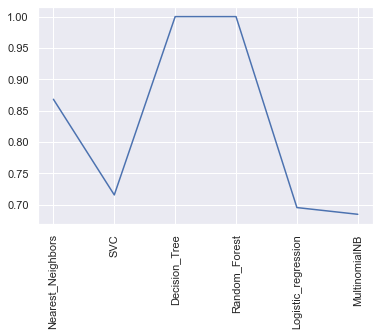

[0.8681192283676755, 0.7156331131486411, 0.999901409839298, 0.999901409839298, 0.6954549935916395, 0.6847415294620264]


In [44]:
plt.plot(names,scores)
plt.xticks(rotation = 90)
plt.show()
print(scores)

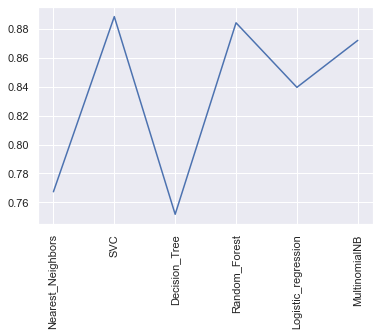

[0.7672955974842768, 0.888504335529009, 0.7517025789885006, 0.8842246287819583, 0.8395668192475159, 0.8720553756838227]


In [45]:
from sklearn.metrics import accuracy_score
acc_score = []
for i in range(6):
    y_predict = classifiers[i].predict(X_valid)
    acc_score.append(accuracy_score(y_valid,y_predict))
    
plt.plot(names, acc_score)
plt.xticks(rotation = 90)
plt.show()
print(acc_score)

In [46]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)


y_predict = clf.predict(X_valid)
accuracy_score(y_valid,y_predict)

C:\Users\WERNER-PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8395668192475159

In [47]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_DTC = {
    'criterion':['gini','entropy'],
    'max_depth':[2,3,4,5,10,50,100,500,1000,None],
    'splitter':['best','random'],
    'min_samples_split':[1,2,5,10,50,100,500,1000,None],
    'min_samples_leaf':[1,2,5,10],
    'max_features':['auto', 'sqrt', 'log2'],
    'random_state':[42]
}
# Create a based model
DTF = DecisionTreeClassifier()
# Instantiate the grid search model
grid_DTF = GridSearchCV(estimator = DTF, param_grid = param_DTC, cv = 3, n_jobs = -1, verbose = 2)

In [48]:
grid_DTF.fit(X_train, y_train)
grid_DTF.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6490 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9730 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 12960 out of 12960 | elapsed:  2.5min finished


{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 500,
 'random_state': 42,
 'splitter': 'best'}

In [49]:
grid_DTF.best_score_

0.724867724867725

In [50]:
grid_DTF.best_estimator_

DecisionTreeClassifier(max_depth=50, max_features='log2', min_samples_leaf=2,
                       min_samples_split=500, random_state=42)

In [51]:
best_dt_model = grid_DTF.best_estimator_
best_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, max_features='log2', min_samples_leaf=2,
                       min_samples_split=500, random_state=42)

In [52]:
DT_pred = best_dt_model.predict(X_valid)

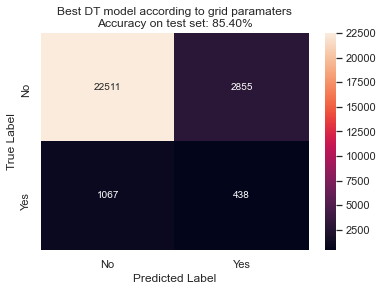

In [53]:
labels = ["No", "Yes"]
sns.heatmap(
    confusion_matrix(y_valid, DT_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_valid, DT_pred) * 100
plt.title("Best DT model according to grid paramaters\nAccuracy on test set: {:.2f}%".format(score))
plt.show()

In [54]:
param_KNN = {
    'n_neighbors':[2,3,4,5,6,7,8,9,10]
}
# Create a based model
KNN = KNeighborsClassifier()
# Instantiate the grid search model
gird_KNN = GridSearchCV(estimator = KNN, param_grid = param_KNN, cv = 3, n_jobs = -1, verbose = 2)

In [55]:
gird_KNN.fit(X_train, y_train)
gird_KNN.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:   43.6s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   51.9s finished


{'n_neighbors': 2}

In [56]:
gird_KNN.best_score_

0.7257221729271418

In [57]:
gird_KNN.best_estimator_

KNeighborsClassifier(n_neighbors=2)

In [58]:
best_KNN_model = gird_KNN.best_estimator_
best_KNN_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [59]:
KNN_pred = best_KNN_model.predict(X_valid)

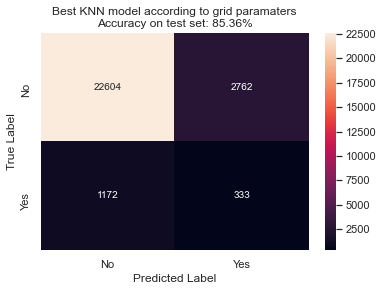

In [60]:
labels = ["No", "Yes"]
y = ['No', 'Yes']
sns.heatmap(
    confusion_matrix(y_valid, KNN_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_valid, KNN_pred) * 100
plt.title("Best KNN model according to grid paramaters\nAccuracy on test set: {:.2f}%".format(score))
plt.show()

In [61]:
param_RFC = {
    'max_depth': [70,80, 90, 100, 110],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
RFC = RandomForestClassifier()
# Instantiate the grid search model
grid_RFC = GridSearchCV(estimator = RFC, param_grid = param_RFC, cv = 3, n_jobs = -1, verbose = 2)

In [62]:
grid_RFC.fit(X_train, y_train)
grid_RFC.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished


{'max_depth': 90, 'n_estimators': 1000}

In [63]:
grid_RFC.best_score_

0.7884583785204903

In [64]:
grid_RFC.best_estimator_

RandomForestClassifier(max_depth=90, n_estimators=1000)

In [65]:
best_RFC_model = grid_RFC.best_estimator_
best_RFC_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=90, n_estimators=1000)

In [66]:
RFC_pred = best_RFC_model.predict(X_valid)

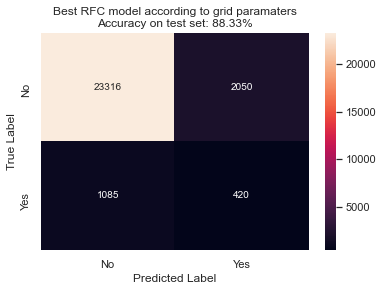

In [67]:
labels = ["No", "Yes"]
y = ['No', 'Yes']
sns.heatmap(
    confusion_matrix(y_valid, RFC_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_valid, RFC_pred) * 100
plt.title("Best RFC model according to grid paramaters\nAccuracy on test set: {:.2f}%".format(score))
plt.show()

In [68]:
param_LR = {
    'penalty': ['l1','l2','elasticnet','none'],
    'tol': [0.1, 0.001, 0.0001, 1,10],
    'C': [1,2,3,4,5,10,15,20,50,100],
    'random_state':[42],
    'solver':['newton-cg','lbfgs','sag','saga'],
    'n_jobs':[-1]
}
# Create a based model
LR = LogisticRegression()
# Instantiate the grid search model
grid_LR = GridSearchCV(estimator = LR, param_grid = param_LR, cv = 3, n_jobs = -1, verbose = 2)

In [69]:
grid_LR.fit(X_train, y_train)
grid_LR.best_params_

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 787 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1174 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1757 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2350 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2377 out of 2400 | elapsed:  7.1min remaining:    4.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  7.5min finished


{'C': 4,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.1}

In [70]:
grid_LR.best_score_

0.6948305892405271

In [71]:
grid_LR.best_estimator_

LogisticRegression(C=4, n_jobs=-1, random_state=42, solver='saga', tol=0.1)

In [72]:
best_LR_model = grid_LR.best_estimator_
best_LR_model.fit(X_train, y_train)

LogisticRegression(C=4, n_jobs=-1, random_state=42, solver='saga', tol=0.1)

In [73]:
LR_pred = best_LR_model.predict(X_valid)

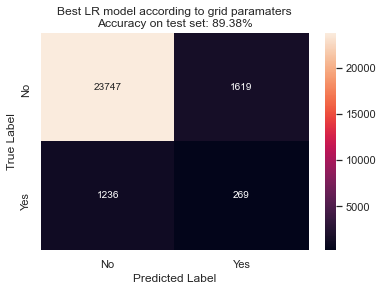

In [74]:
labels = ["No", "Yes"]
y = ['No', 'Yes']
sns.heatmap(
    confusion_matrix(y_valid, LR_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_valid, LR_pred) * 100
plt.title("Best LR model according to grid paramaters\nAccuracy on test set: {:.2f}%".format(score))
plt.show()

In [75]:
MNB = MultinomialNB()

In [76]:
MNB.fit(X_train, y_train)

MultinomialNB()

In [77]:
MNB_pred = MNB.predict(X_valid)

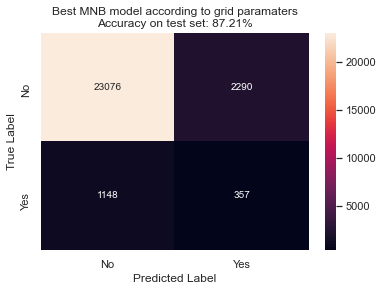

In [78]:
labels = ["No", "Yes"]
y = ['No', 'Yes']
sns.heatmap(
    confusion_matrix(y_valid, MNB_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_valid, MNB_pred) * 100
plt.title("Best MNB model according to grid paramaters\nAccuracy on test set: {:.2f}%".format(score))
plt.show()

In [86]:
param_SVC = {
    'kernel':['poly'],
    'degree':[2,3,4,5,6,7,8,9,10]
}
# Create a based model
SVC_ = SVC()
# Instantiate the grid search model
grid_SVC = GridSearchCV(estimator = SVC_, param_grid = param_SVC, cv = 3, n_jobs = -1, verbose = 2)

In [87]:
grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  6.7min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  7.6min finished


{'degree': 10, 'kernel': 'poly'}

In [88]:
grid_SVC.best_score_

0.7241118669690098

In [89]:
grid_SVC.best_estimator_

SVC(degree=10, kernel='poly')

In [90]:
best_SVC_model = grid_SVC.best_estimator_
best_SVC_model.fit(X_train, y_train)

SVC(degree=10, kernel='poly')

In [91]:
SVC_pred = best_SVC_model.predict(X_valid)

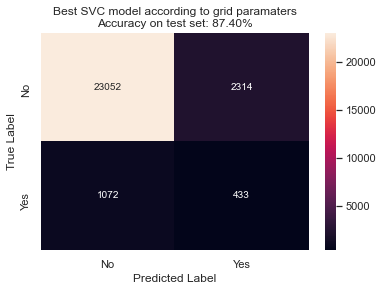

In [92]:
labels = ["No", "Yes"]
y = ['No', 'Yes']
sns.heatmap(
    confusion_matrix(y_valid, SVC_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
score = accuracy_score(y_valid, SVC_pred) * 100
plt.title("Best SVC model according to grid paramaters\nAccuracy on test set: {:.2f}%".format(score))
plt.show()

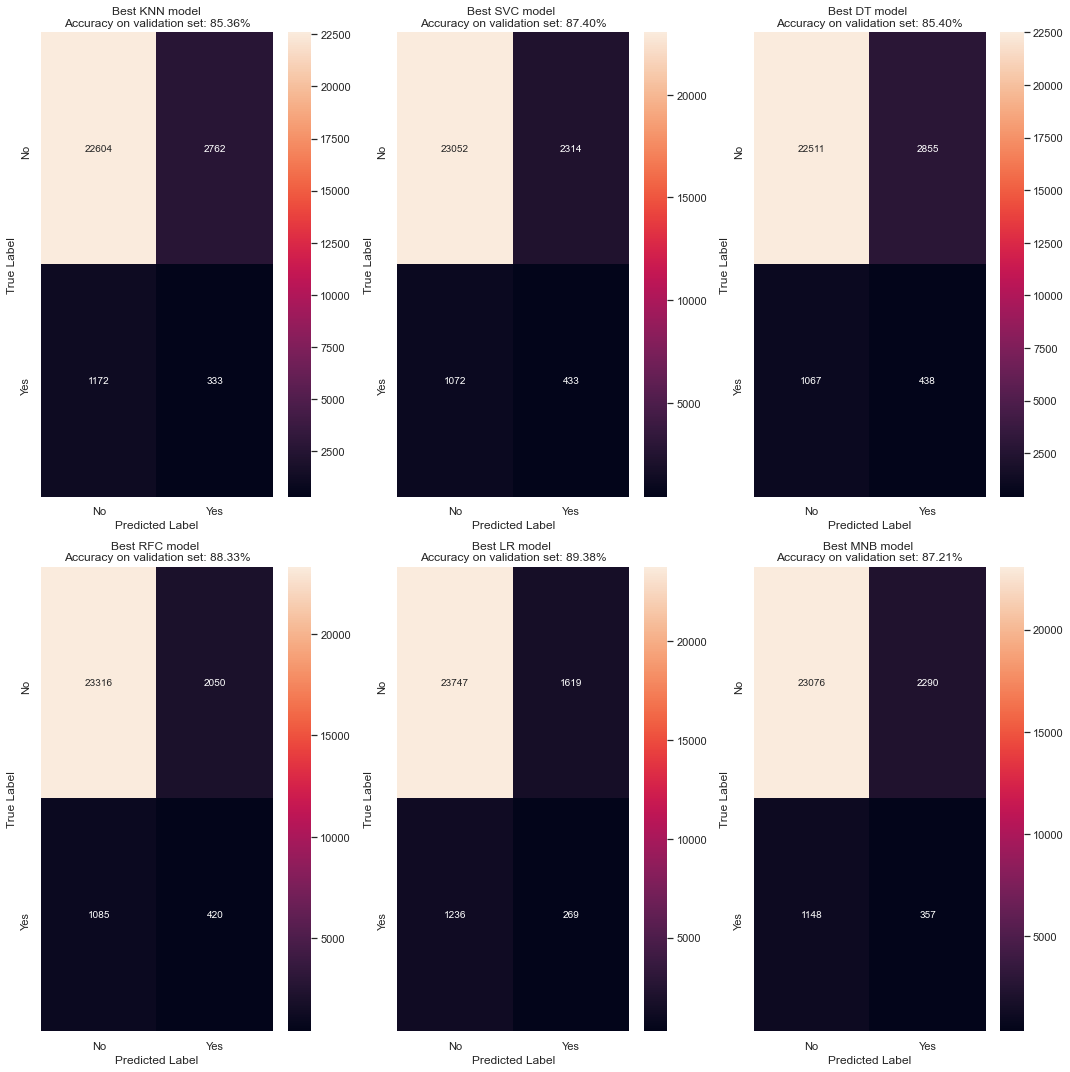

In [103]:
fig , ax = plt.subplots(2,3,figsize=(15,15))
ax = ax.flatten()
labels = ["No", "Yes"]

sns.heatmap(
    confusion_matrix(y_valid, KNN_pred),
    annot=True,fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[0]
)
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')
score = accuracy_score(y_valid, KNN_pred) * 100
ax[0].set_title("Best KNN model\nAccuracy on validation set: {:.2f}%".format(score))


sns.heatmap(
    confusion_matrix(y_valid, SVC_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[1]
)
ax[1].set_ylabel('True Label')
ax[1].set_xlabel('Predicted Label')
score = accuracy_score(y_valid, SVC_pred) * 100
ax[1].set_title("Best SVC model \nAccuracy on validation set: {:.2f}%".format(score))

sns.heatmap(
    confusion_matrix(y_valid, DT_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[2]
)
ax[2].set_ylabel('True Label')
ax[2].set_xlabel('Predicted Label')
score = accuracy_score(y_valid, DT_pred) * 100
ax[2].set_title("Best DT model \nAccuracy on validation set: {:.2f}%".format(score))

sns.heatmap(
    confusion_matrix(y_valid, RFC_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[3]
)
ax[3].set_ylabel('True Label')
ax[3].set_xlabel('Predicted Label')
score = accuracy_score(y_valid, RFC_pred) * 100
ax[3].set_title("Best RFC model \nAccuracy on validation set: {:.2f}%".format(score))

sns.heatmap(
    confusion_matrix(y_valid, LR_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[4]
)
ax[4].set_ylabel('True Label')
ax[4].set_xlabel('Predicted Label')
score = accuracy_score(y_valid, LR_pred) * 100
ax[4].set_title("Best LR model \nAccuracy on validation set: {:.2f}%".format(score))

sns.heatmap(
    confusion_matrix(y_valid, MNB_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[5]
)
ax[5].set_ylabel('True Label')
ax[5].set_xlabel('Predicted Label')
score = accuracy_score(y_valid, MNB_pred) * 100
ax[5].set_title("Best MNB model \nAccuracy on validation set: {:.2f}%".format(score))


plt.tight_layout()
#"Nearest_Neighbors",'SVC', "Decision_Tree", "Random_Forest", "Logistic_regression",
#"Naive_Bayes"